In [1]:
import torch
import numpy as np 
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Optimizer
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from useful_functions import *
from optimizer import *
from model import *
from MNIST_data_process import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from training import *
from mlxtend.data import mnist_data
from accuracy_compute import *
from data_preparation_easy import *
from data_preparation_hard import *
from network_func import *
from search_parameter import *
import optuna
from CIFAR10_model import *
from CIFAR10_data_preparation import *
from useful_model import *
import sys
sys.path.append('/root/GanLuo/PullSum_MNIST/code/神经网络实验')
from models_complex import *

In [4]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()  # 将模型设置为训练模式
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 计算训练损失和准确性
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    print(f"Train Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

# 测试循环
def test(model, device, test_loader, criterion):
    model.eval()  # 将模型设置为评估模式a
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():  # 在测试过程中不计算梯度
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # 计算准确性
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / total
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

# 假设已经加载了 CIFAR-10 数据并准备好训练和测试数据
X_train, X_test, y_train, y_test = load_cifar10_data()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 将数据转换为 Tensor 并移动到设备 (GPU 或 CPU)
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# 定义模型、损失函数和优化器
""" model = models.resnet18()   #.to(device)#SimpleResNet1().to(device)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.to(device) """

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载 MobileNetV2 模型，使用 weights 参数
model = models.mobilenet_v2(weights=None)  # 先创建模型

# 加载本地权重
model.load_state_dict(torch.load('/root/GanLuo/PullSum_MNIST/code/神经网络实验/预训练模型权重/mobilenet_v2-7ebf99e0.pth'))
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 10)
model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)

# 假设已经定义了批量大小
batch_size = 128

# 创建数据加载器
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 训练循环
num_epochs = 20

L1,L2,A1,A2=[], [], [], []

# 运行训练和测试循环
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    Trian_loss,Trian_accuracy = train(model, device, train_loader, optimizer, criterion)
    Test_loss,Test_accuracy = test(model, device, test_loader, criterion)
    L1.append(Trian_loss)
    L2.append(Test_loss)    
    A1.append(Trian_accuracy)
    A2.append(Test_accuracy)

Epoch [1/20]
Train Loss: 1.7096, Accuracy: 40.12%
Test Loss: 1.3069, Accuracy: 55.75%
Epoch [2/20]
Train Loss: 1.1418, Accuracy: 60.20%
Test Loss: 1.0271, Accuracy: 64.19%
Epoch [3/20]
Train Loss: 0.9305, Accuracy: 67.83%
Test Loss: 0.8751, Accuracy: 69.45%
Epoch [4/20]
Train Loss: 0.8097, Accuracy: 71.95%
Test Loss: 0.8046, Accuracy: 72.19%
Epoch [5/20]
Train Loss: 0.7277, Accuracy: 74.62%
Test Loss: 0.7540, Accuracy: 73.59%
Epoch [6/20]
Train Loss: 0.6633, Accuracy: 77.11%
Test Loss: 0.7228, Accuracy: 75.21%
Epoch [7/20]
Train Loss: 0.6093, Accuracy: 78.68%
Test Loss: 0.7024, Accuracy: 75.95%
Epoch [8/20]
Train Loss: 0.5656, Accuracy: 80.14%
Test Loss: 0.6828, Accuracy: 76.40%
Epoch [9/20]
Train Loss: 0.5228, Accuracy: 81.53%
Test Loss: 0.6772, Accuracy: 76.67%
Epoch [10/20]
Train Loss: 0.4859, Accuracy: 82.85%
Test Loss: 0.6642, Accuracy: 77.41%
Epoch [11/20]
Train Loss: 0.4558, Accuracy: 83.87%
Test Loss: 0.6653, Accuracy: 77.52%
Epoch [12/20]


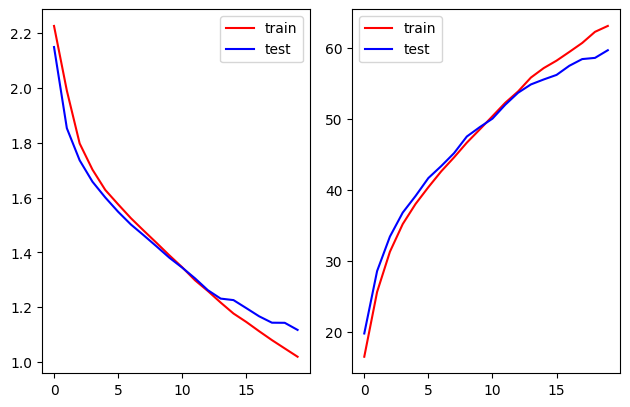

In [12]:
plt.subplot(1,2,1)
plt.plot(L1,color='r',label='train')
plt.plot(L2,color='b',label='test')
plt.legend()

plt.subplot(1,2,2)
plt.plot(A1,color='r',label='train')
plt.plot(A2,color='b',label='test')
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.90]) 
plt.show()